In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q datasets albumentations


In [71]:
import pandas as pd
from PIL import Image

In [72]:
meta = pd.read_csv('Bag-Data/metadata')

In [73]:
import os

image_fold = os.listdir('Bag-Data/data')
mask_fold = os.listdir('Bag-Data/masks')

In [74]:
image_files = []

for image in image_fold:
    if image.endswith('jpg'):
        image_files.append(image)

mask_files = []

for mask in mask_fold:
    if mask.endswith('png'):
        mask_files.append(mask)

print(len(image_files))

3234


In [75]:
meta.head()

,Unnamed: 0,MaskPath,ImageID,LabelName,BoxID,BoxXMin,BoxXMax,BoxYMin,BoxYMax,PredictedIoU,Clicks
0,0,80e90b871bbde2b8_m080hkjn_694cc770.png,80e90b871bbde2b8,/m/080hkjn,694cc770,0.012320,0.991786,0.022222,0.988889,0.0,NaN
1,1,5a6a4b7bb3362ff0_m01940j_80808d65.png,5a6a4b7bb3362ff0,/m/01940j,80808d65,0.167870,0.711191,0.128159,0.980144,0.0,NaN
2,2,3e6d6b4d610675b1_m01940j_98391b9b.png,3e6d6b4d610675b1,/m/01940j,98391b9b,0.509395,0.787056,0.585938,0.870313,0.0,NaN
3,3,3268431ea960dbc8_m01940j_70cd2aef.png,3268431ea960dbc8,/m/01940j,70cd2aef,0.135379,0.485560,0.617329,0.835740,0.0,NaN
4,4,21b96c340298be53_m080hkjn_744d597c.png,21b96c340298be53,/m/080hkjn,744d597c,0.004762,0.521429,0.070632,0.881041,0.0,NaN


In [76]:
import numpy as np



In [96]:
id2label = {0 : 'bag'}

from transformers import MaskFormerImageProcessor

processor = MaskFormerImageProcessor(reduce_labels=True, ignore_index=255, do_resize=False, do_rescale=False, do_normalize=False)



Next, we format images and annotations and put them in a dict

In [78]:


data = []


for img in image_files:
    ImageID = img[0:-4]
    image_meta = meta[meta['ImageID'] == ImageID]
    msks = []
    for i, mask_file in image_meta.iterrows():
        msks.append(mask_file['MaskPath'])
    data_entry = [img, msks]
    data.append(data_entry)


    
    





In [79]:


processor = MaskFormerImageProcessor(do_reduce_labels=True, ignore_index=255, do_resize=False, do_rescale=False, do_normalize=False)

In [80]:
import torch
from torch.utils.data import Dataset

In [81]:
import albumentations as A

ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

transform = A.Compose([
    A.Resize(width=512, height=512),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])

In [98]:
class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, dataset, processor, transform=None):
        """
        Args:
            dataset
        """
        self.dataset = dataset
        self.processor = processor
        self.transform = transform
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image = np.array(Image.open(f'Bag-Data/data/{self.dataset[idx][0]}').convert("RGB"))

        annotation = []
        x = 1
        for mask_file in self.dataset[idx][1]:
            mask = Image.open(f'Bag-Data/masks/{mask_file}').convert('RGB')
            mask_arr = np.array(mask)
            if x == 1:
                annotation = np.zeros(mask_arr.shape)
            collapsed = np.sum(mask_arr, axis = 2)
            collapsed[collapsed != 0] = 1
            annotation[ :, :, 0] += collapsed
            annotation[ :, :, 1] += np.multiply(collapsed, x)
            x += 1

        
        


        instance_seg = annotation[ :, :, 1]
        class_id_map = annotation[ :, :, 0]

        
        inst2class = {}
        instance_ids = np.unique(instance_seg[class_id_map != 0])
        inst2class.update({i: 1 for i in instance_ids})


        # apply transforms
        if self.transform is not None:
            transformed = self.transform(image=image, mask=instance_seg)
            image, instance_seg = transformed['image'], transformed['mask']
            # convert to C, H, W
            image = image.transpose(2,0,1)


        inputs = self.processor([image], [instance_seg], instance_id_to_semantic_id=inst2class, return_tensors="pt")
        inputs = {k: v.squeeze() if isinstance(v, torch.Tensor) else v[0] for k,v in inputs.items()}

        return inputs

In [99]:
dataset = ImageSegmentationDataset(data,processor,transform)

In [100]:
from torch.utils.data import DataLoader 

def collate_fn(batch):
    pixel_values = torch.stack([example["pixel_values"] for example in batch])
    pixel_mask = torch.stack([example["pixel_mask"] for example in batch])
    class_labels = [example["class_labels"] for example in batch]
    mask_labels = [example["mask_labels"] for example in batch]
    return {"pixel_values": pixel_values, "pixel_mask": pixel_mask, "class_labels": class_labels, "mask_labels": mask_labels}

train_dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

In [103]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,len(v))

pixel_values torch.Size([4, 3, 512, 512])
pixel_mask torch.Size([4, 512, 512])
class_labels 4
mask_labels 4


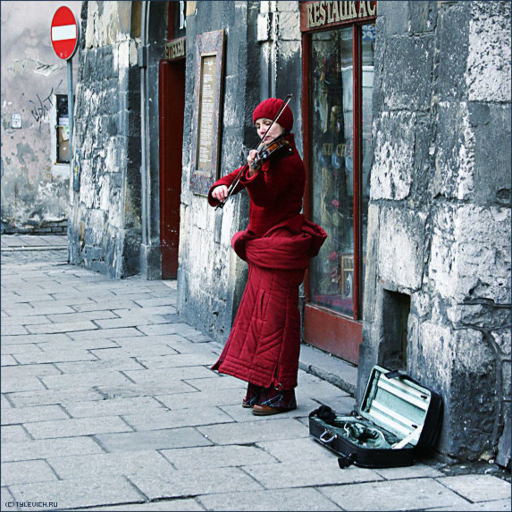

In [86]:
ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

batch_index = 1

unnormalized_image = (batch["pixel_values"][batch_index].numpy() * np.array(ADE_STD)[:, None, None]) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

In [87]:
batch["class_labels"][batch_index]

tensor([0])

In [88]:
id2label[0]

'bag'

Visualizing mask for: bag


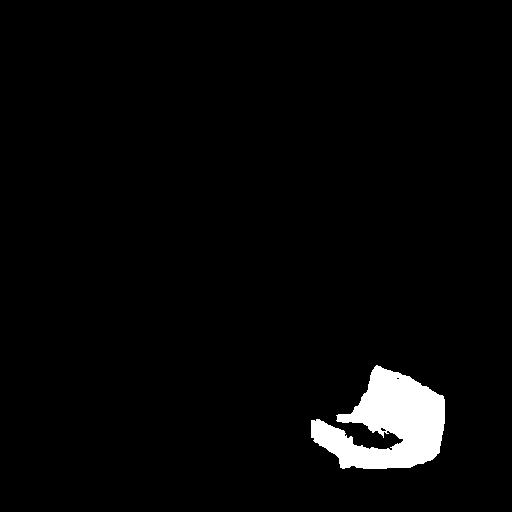

In [89]:
print("Visualizing mask for:", id2label[batch["class_labels"][batch_index][0].item()])

visual_mask = (batch["mask_labels"][batch_index][0].bool().numpy() * 255).astype(np.uint8)
Image.fromarray(visual_mask)


In [91]:
from transformers import MaskFormerForInstanceSegmentation

# Replace the head of the pre-trained model
# We specify ignore_mismatched_sizes=True to replace the already fine-tuned classification head by a new one
model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-base-ade",
                                                          id2label=id2label,
                                                          ignore_mismatched_sizes=True)

Some weights of MaskFormerForInstanceSegmentation were not initialized from the model checkpoint at facebook/maskformer-swin-base-ade and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([2]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [94]:
from IPython.display import display, Javascript

scroll_js = """
require(
    ["base/js/namespace", "notebook/js/outputarea"],
    function(Jupyter, outputarea) {
        outputarea.OutputArea.prototype._should_scroll = function(lines) {
            return true;
        };
    }
);
"""

display(Javascript(data=scroll_js))

<IPython.core.display.Javascript object>

In [107]:
import torch
from tqdm.auto import tqdm





device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

running_loss = 0.0
num_samples = 0
for epoch in range(5):
  print("Epoch:", epoch)
  model.train()
  for idx, batch in enumerate(tqdm(train_dataloader)):
      
    # Reset the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(
            pixel_values=batch["pixel_values"].to(device),
            mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
            class_labels=[labels.to(device) for labels in batch["class_labels"]],
    )

    # Backward propagation
    loss = outputs.loss
    loss.backward()

    batch_size = batch["pixel_values"].size(0)
    running_loss += loss.item()
    num_samples += batch_size

    if idx % 100 == 0:
        print("Loss:", running_loss/num_samples)

    # Optimization
    
    optimizer.step()


Epoch: 0


  0%|          | 0/809 [00:00<?, ?it/s]

Loss: 0.2038564831018448


 12%|█▏        | 100/809 [41:11<4:28:12, 22.70s/it]

Loss: 0.23938487300483308


 25%|██▍       | 200/809 [1:32:29<7:23:23, 43.68s/it]  

Loss: 0.22889795929045226


 37%|███▋      | 300/809 [2:39:54<3:15:23, 23.03s/it]  

Loss: 0.21822933029643324


 49%|████▉     | 400/809 [5:17:00<6:56:28, 61.10s/it]  

Loss: 0.21704736323167856


 62%|██████▏   | 500/809 [5:53:53<1:56:56, 22.71s/it]

Loss: 0.21535756454585556


 74%|███████▍  | 600/809 [6:31:26<1:17:08, 22.15s/it]

Loss: 0.21362530774190502


 87%|████████▋ | 700/809 [7:08:34<40:25, 22.25s/it]  

Loss: 0.21168257926355585


 99%|█████████▉| 800/809 [7:46:15<03:22, 22.45s/it]

Loss: 0.20864679417415952


100%|██████████| 809/809 [7:49:17<00:00, 34.81s/it]


Epoch: 1


  0%|          | 0/809 [00:00<?, ?it/s]

Loss: 0.20871068789883113


 12%|█▏        | 100/809 [37:34<4:28:32, 22.73s/it]

Loss: 0.20714074293783302


 25%|██▍       | 200/809 [1:14:58<3:52:25, 22.90s/it]

Loss: 0.20450469903526122


 30%|██▉       | 242/809 [1:34:17<3:40:54, 23.38s/it]


KeyboardInterrupt: 